In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [4]:
# Cell 1 - Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [5]:
# Cell 2 - load file (make sure you've already extracted the zip to /content/air_quality)
DATA_DIR = "/content/air_quality"
CSV_PATH = os.path.join(DATA_DIR, "city_day.csv")

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found. If you're in Colab, re-upload archive and extract or change path.")

df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
df.head()


FileNotFoundError: /content/air_quality/city_day.csv not found. If you're in Colab, re-upload archive and extract or change path.

In [6]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1) (1).zip


In [7]:
import zipfile
import os

zip_path = "/content/archive (1).zip"   # check the name after upload
extract_dir = "/content/air_quality"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted files:", os.listdir(extract_dir))


Extracted files: ['stations.csv', 'station_day.csv', 'city_hour.csv', 'station_hour.csv', 'city_day.csv']


In [8]:
import pandas as pd

CSV_PATH = "/content/air_quality/city_day.csv"
df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (29531, 16)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [9]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
df.info()


Shape: (29531, 16)
Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
Missing values:
 City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3   

In [10]:
# Convert Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Drop rows with < 5 valid values
df = df.dropna(thresh=5).reset_index(drop=True)

# Fill missing with forward/backward fill
df = df.ffill().bfill()

# Drop rows without AQI
df = df.dropna(subset=['AQI']).reset_index(drop=True)

print("Shape after cleaning:", df.shape)


Shape after cleaning: (27851, 16)


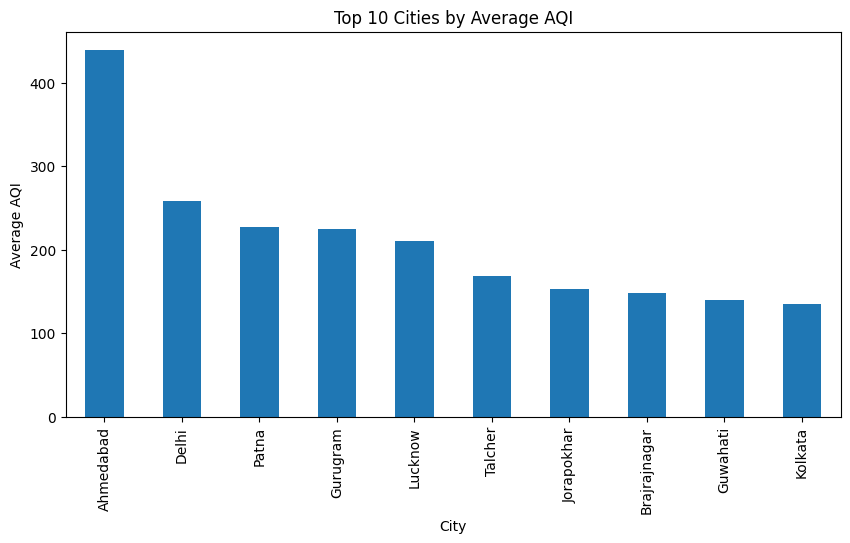

In [11]:
import matplotlib.pyplot as plt

city_aqi = df.groupby("City")["AQI"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
city_aqi.plot(kind="bar")
plt.title("Top 10 Cities by Average AQI")
plt.ylabel("Average AQI")
plt.show()



In [12]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek


In [13]:
X = df.drop(columns=["AQI", "AQI_Bucket", "Date"])
y = df["AQI"].astype(float)


In [14]:
n = len(X)
cut = int(n*0.8)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (22280, 17) Test: (5571, 17)


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identify categorical & numeric columns
categorical_cols = ["City"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing
numeric_transformer = SimpleImputer(strategy="mean")
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Create pipeline with Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", LinearRegression())])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred = lr_pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print("RMSE:", rmse)
print("R² Score:", r2)


Linear Regression Results:
RMSE: 53.63199292082744
R² Score: 0.7410443810766707


In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", RandomForestRegressor(n_estimators=100, random_state=42))])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print("RMSE:", rmse_rf)
print("R² Score:", r2_rf)


Random Forest Results:
RMSE: 44.81061455633222
R² Score: 0.819224626056686


In [18]:
from sklearn.tree import DecisionTreeRegressor

dt_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", DecisionTreeRegressor(random_state=42))])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Results:")
print("RMSE:", rmse_dt)
print("R² Score:", r2_dt)


Decision Tree Results:
RMSE: 68.99942377341021
R² Score: 0.5713839830709516


In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", RandomForestRegressor(n_estimators=100, random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))



Random Forest Results:
RMSE: 44.81061455633222
R² Score: 0.819224626056686


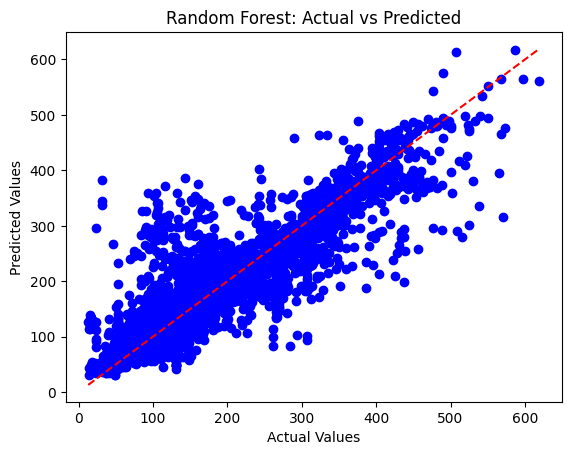

In [20]:
import matplotlib.pyplot as plt

# y_test = actual values
# y_pred_rf = predicted values from Random Forest

plt.scatter(y_test, y_pred_rf, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.show()
